<a href="https://colab.research.google.com/github/Flor-Si/Entrega-3-Grupo-4-/blob/main/Entrega_3_(Parte_2)_Grupo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# :::::***Trabajo Final  detección de Fraudes*** :::::

# **PARTE 2**

#### En el presente trabajo se analizo un dataset con técnicas de Machine Learning.
#### El objetivo princial fue detectar posibles patrones de fraude utilizando técnicas de aprendizaje automático.
#### Este trabajo busca automatizar tareas de análisis de datos, mejorar la toma de decisiones y optimizar recursos en entornos reales mediante la utilización de la herramienta Python.

#### Trabajaremos con el archivo en formato .csv, obtenido en la **PARTE 1**.
#### El dataset resultante aparece con la denominación **"df_final"**. El dataset se encuentra alojado en el Drive debido a que su tamaño supera los 25 MB permitidos por GitHub.


## ***Importación de librerias***

In [ ]:
# Importación de las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, recall_score, f1_score, precision_score
from xgboost import XGBClassifier


In [ ]:
# Importación de la base de datos usando Drive
from google.colab import drive
drive.mount('/content/drive')
df_final = pd.read_csv('/content/drive/MyDrive/Entrega_3/df_final.csv')

Mounted at /content/drive


#### Corroboramos e inspeccionamos el dataset resultante de la **PARTE 1**.

In [ ]:
# Verificar nombres de columnas
df_final.head()

,Unnamed: 0,step,amount,isFraud,dia,hora,type_CASH_OUT,type_TRANSFER
0,0,1,181.00,1,0,1,0,1
1,1,1,181.00,1,0,1,1,0
2,2,1,229133.94,0,0,1,1,0
3,3,1,215310.30,0,0,1,0,1
4,4,1,311685.89,0,0,1,0,1


In [ ]:
df_final = df_final.drop(['Unnamed: 0'], axis=1)
df_final

,step,amount,isFraud,dia,hora,type_CASH_OUT,type_TRANSFER
0,1,181.00,1,0,1,0,1
1,1,181.00,1,0,1,1,0
2,1,229133.94,0,0,1,1,0
3,1,215310.30,0,0,1,0,1
4,1,311685.89,0,0,1,0,1
...,...,...,...,...,...,...,...
2770404,743,339682.13,1,31,23,1,0
2770405,743,6311409.28,1,31,23,0,1
2770406,743,6311409.28,1,31,23,1,0
2770407,743,850002.52,1,31,23,0,1


In [ ]:
# Análisis de la cantidad de filas y columnas
df_final.shape

(2770409, 7)

**Realizamos un submuestreo**:

Es una estrategia de balanceo de datos donde se reduce el número
de instancias de la clase mayoritaria para que coincida, o se acerque, al número de instancias de la clase minoritaria. Es una técnica sencilla y directa que busca equilibrar las proporciones entre las clases, lo que puede ayudar a los modelos de aprendizaje automático a no sesgarse hacia la clase mayoritaria. Para ello utilizamos la librería resample.

In [ ]:
# Vamos a usar una relacion de 1:10 --> 1 fraude == 10 No Fraude
from sklearn.utils import resample

# Dividimos
df_fraude = df_final[df_final.isFraud == 1]
df_no_fraude = df_final[df_final.isFraud == 0]

# Submuestreo
df_no_fraude_bal = resample(df_no_fraude,
                            replace=False,
                            n_samples=len(df_fraude) * 10,  # relación 1:10
                            random_state=42)

# Dataset balanceado
df_balanceado = pd.concat([df_fraude, df_no_fraude_bal])


#### Tratamos de obtener el mejor balanceo para realizar la validación cruzada y determinar qué modelo vamos a utilizar según los datos obtenidos.

In [ ]:
# Realizamos el balanceo 1
df_balanceado[(df_balanceado['isFraud']==0) & ((df_balanceado['type_CASH_OUT']==1) | (df_balanceado['type_TRANSFER']==1))][['type_CASH_OUT','type_TRANSFER']].value_counts()

,,count
type_CASH_OUT,type_TRANSFER,
1,0,99645
0,1,23550


In [ ]:
# Realizamos el balanceo 2
df_balanceado[(df_balanceado['isFraud']==1) & ((df_balanceado['type_CASH_OUT']==1) | (df_balanceado['type_TRANSFER']==1))][['type_CASH_OUT','type_TRANSFER']].value_counts()

,,count
type_CASH_OUT,type_TRANSFER,
1,0,4116
0,1,4097


#### Aplicamos el modelo **Random Forest Classifier** para resolver problemas de clasificación.

#### Sabemos que RandomForestClassifier es un algoritmo supervisado de clasificación. Está basado en la construcción de múltiples árboles de decisión independientes que operan en paralelo. Cada árbol es entrenado sobre una muestra aleatoria del dataset original.

#### La clasificación en nuestro modelo es fraude (1) y No fraude (0).



In [ ]:
from sklearn.model_selection import train_test_split

X = df_balanceado.drop(columns=['isFraud'])
y = df_balanceado['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Modelo RandomForestClassifier
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


[[36372   587]
 [  849  1615]]
              precision    recall  f1-score   support

           0     0.9772    0.9841    0.9806     36959
           1     0.7334    0.6554    0.6922      2464

    accuracy                         0.9636     39423
   macro avg     0.8553    0.8198    0.8364     39423
weighted avg     0.9620    0.9636    0.9626     39423



#### Para el modelo Random Forest vemos que los datos obtenidos de recall y precisión están muy lejos de los valores óptimos.

#### Aplicamos feature importances para obtener variables que tenga más peso en las deciciones de nuestro modelo de datos










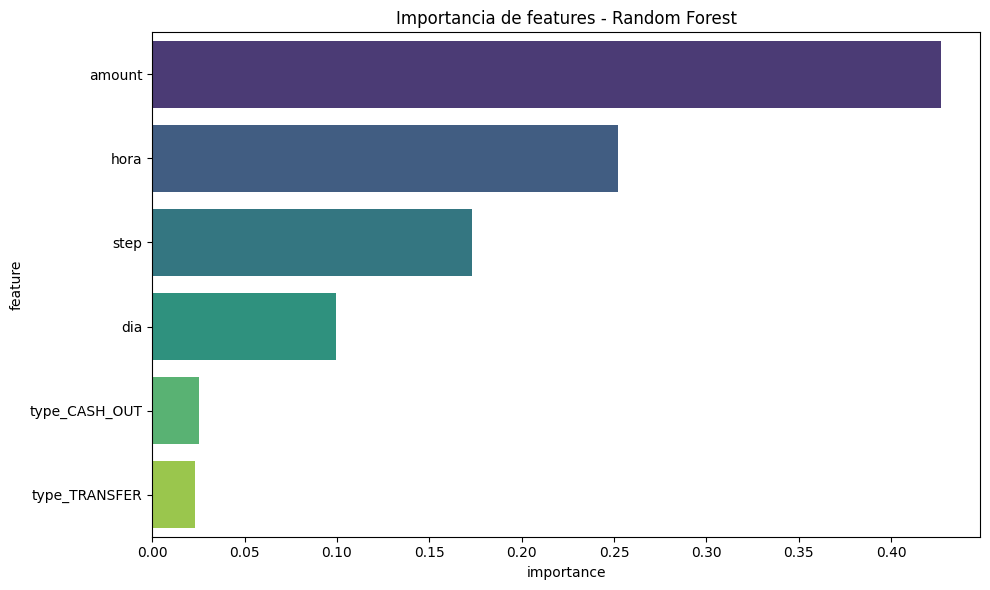

In [ ]:
# Obtener nombres de columnas
features = X_train.columns

# Importancia de cada feature
importancias = modelo.feature_importances_

# Armar dataframe ordenado
df_importancias = pd.DataFrame({
    'feature': features,
    'importance': importancias
}).sort_values(by='importance', ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
sns.barplot(data=df_importancias, x='importance', y='feature', palette='viridis')
plt.title('Importancia de features - Random Forest')
plt.tight_layout()
plt.show()


#### En el gráfico se observa la importancia de los features. El feature con mayor peso es "amount", correspondiente a los montos de dinero de las transacciones.

### Validacion cruzada

#### Utilizamos validación cruzada para estimar como se comporta nuestro modelo de datos. Dividimos nuestro dataset en múltiples subconjuntos a los cuales  entrenamos y evaluamos en diferentes combinaciones.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score
# Modelo
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42, n_jobs=-1)

# Estrategia de validación cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Usamos F1 como métrica principal, pero se puede cambiar a roc_auc, recall,f1_score, precision, etc.
scorer = make_scorer(recall_score)

# Ejecutamos la validación cruzada
scores = cross_val_score(rf, X, y, cv=cv, scoring=scorer)

print("F1 por fold:", scores)
print("F1 promedio:", np.mean(scores))


F1 por fold: [0.65328467 0.62895377 0.64111922 0.62971985 0.65529842 0.6589525
 0.63946407 0.6406821  0.64311815 0.67600487]
F1 promedio: 0.6466597615512504


###  ⚖️ F1-Score (Nos determina lo siguiente):

> Media armónica entre precisión y recall.

**Fórmula:**

$$
F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
$$

**Ventaja:** Balancea los dos errores. Ideal en clases desbalanceadas.

#### Vamos a probar con los datos sin balanceo

****Aplicamos Random Forest y Evaluamos****


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df_final.drop(columns=['isFraud'])
y = df_final['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

[[827982    677]
 [  1183   1281]]
              precision    recall  f1-score   support

           0     0.9986    0.9992    0.9989    828659
           1     0.6542    0.5199    0.5794      2464

    accuracy                         0.9978    831123
   macro avg     0.8264    0.7595    0.7891    831123
weighted avg     0.9976    0.9978    0.9976    831123



#### Para este caso los valores  obtenidos son menores a la ejecución anterior generando un valor poco favorable para nuestro análisis.

#### Importancia de Features con dataset sin modificacion

Atributo: amount, Importancia: 0.5284
Atributo: step, Importancia: 0.1840
Atributo: hora, Importancia: 0.1524
Atributo: dia, Importancia: 0.0870
Atributo: type_CASH_OUT, Importancia: 0.0270
Atributo: type_TRANSFER, Importancia: 0.0211


/tmp/ipython-input-15-2727322930.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancias, x='importance', y='feature', palette='viridis')


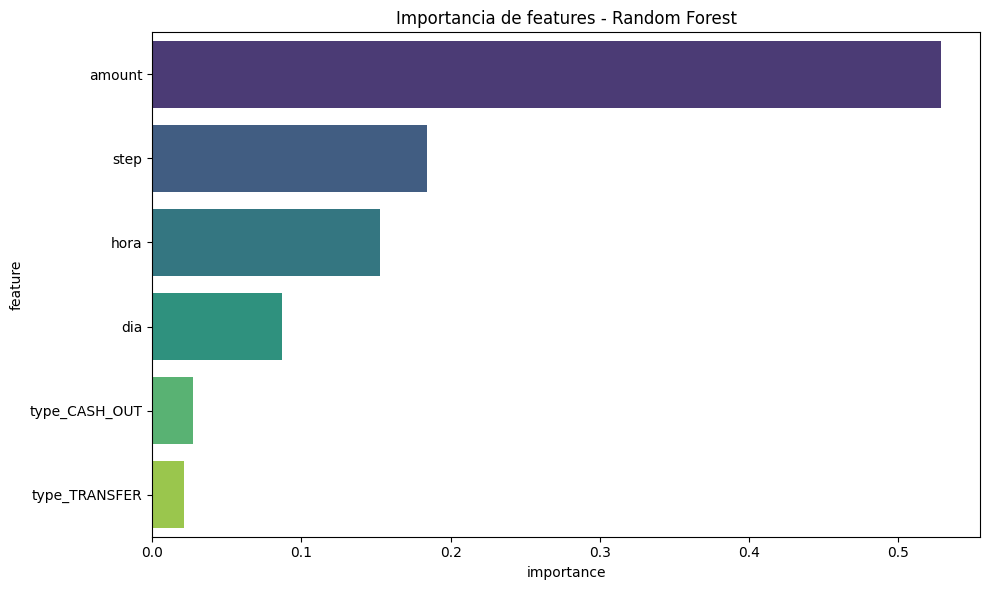

In [ ]:
# Obtener nombres de columnas
features = X_train.columns

# Importancia de cada feature
importancias = modelo.feature_importances_

# Armar dataframe ordenado
df_importancias = pd.DataFrame({
    'feature': features,
    'importance': importancias
}).sort_values(by='importance', ascending=False)

# Iterar a través del DataFrame df_importancias para imprimir los atributos y sus importancias
for index, row in df_importancias.iterrows():
    print(f'Atributo: {row["feature"]}, Importancia: {row["importance"]:.4f}')

# Visualizar
plt.figure(figsize=(10, 6))
sns.barplot(data=df_importancias, x='importance', y='feature', palette='viridis')
plt.title('Importancia de features - Random Forest')
plt.tight_layout()
plt.show()

#### Vamos a probar con el modelo **XGBoost** para ver la diferencia con los valores de **RandomForest**

####  **XGBoost** emplea un enfoque secuencial y aditivo, donde cada nuevo árbol se entrena para corregir los errores residuales de los árboles anteriores, por todo lo mensionado anterirmente se considera mejor que **Random Forest**.

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# Crear el modelo
model = XGBClassifier()

# Entrenar
model.fit(X_train, y_train)

# Predecir
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

[[828576     83]
 [  1298   1166]]
              precision    recall  f1-score   support

           0     0.9984    0.9999    0.9992    828659
           1     0.9335    0.4732    0.6281      2464

    accuracy                         0.9983    831123
   macro avg     0.9660    0.7366    0.8136    831123
weighted avg     0.9982    0.9983    0.9981    831123



#### Si bien la precisión es alta, nuestro objetivo es detectar más fraudes. Esto ultimo lo determina nuestro recall, cercano a 100%. Por lo mencionado, descartamos los datos anteriormente ejecutados.

#### Ahora usamos scale_pos_weight ajustado al desbalance (esto sirve para decirle al modelo que aunque sean pocos los fraudes, son muy importantes).

#### Usamos **StratifiedKFold** que es una variante del método de validación cruzada y, de esta manera, aseguramos que cada partición de entrenamiento y validación tenga una distribución similar de clases al conjunto original.

#### El objetivo es evitar que alguna partición tenga demasiados ejemplos o clases y poca de otras, lo cual puede sesgar la evaluación del modelo.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Calculamos el peso: cantidad de no-fraude / cantidad de fraude
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

# Modelo XGBoost
xgb = XGBClassifier(
    eval_metric=['aucpr', 'logloss'],
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Validación cruzada con F1
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1 = make_scorer(f1_score)
scores = cross_val_score(xgb, X, y, cv=cv, scoring=f1)

print("F1 por fold:", scores)
print("F1 promedio:", np.mean(scores))


F1 por fold: [0.06159009 0.06067894 0.06138084 0.05898951 0.06100808 0.0611066
 0.06022845 0.05823444 0.06039108 0.06205272]
F1 promedio: 0.06056607490531616


### Ahora usamos **SMOTE** que crea una copia sintética de los fraudes para que haya más y el modelo lo aprenda mejor.

#### Sabemos que el **SMOTE** es una técnica de oversampling utilizada para balancear conjuntos de datos desbalanceados, especialmente con problemas de clasificación binaria donde una clase (la minoritaria) tiene muy pocos ejemplos en comparación con la clase mayoritaria.


#### Importamos **imbalanced-learn** con la cual podremos tratar datasets desbalanceados con problemas de clasificación supervisada.

In [ ]:
# Instalación de librería
!pip install imbalanced-learn


In [ ]:
# Importar SMOTE desde la librería
from imblearn.over_sampling import SMOTE

In [ ]:
X = df_final.drop(columns=['isFraud'])
y = df_final['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score

# SMOTE para oversampling
# Con oversampling para modelos supervisados con problemas de clases desbalanceadas
smote = SMOTE(random_state=42)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Pipeline: primero SMOTE, luego Random Forest
pipeline = Pipeline([
    ('smote', smote),
    ('rf', rf)
])

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1 = make_scorer(f1_score)

# Evaluación con F1-score
scores = cross_val_score(pipeline, X, y, cv=cv, scoring=f1)

print("F1 por fold:", scores)
print("F1 promedio:", np.mean(scores))


F1 por fold: [0.43537999 0.42086957 0.44121532 0.43155032 0.43429069 0.42888595
 0.4314587  0.4391771  0.43079662 0.44280122]
F1 promedio: 0.4336425475545217


#### Aplicamos ***ADASYN ***que es una técnica de oversampling para el tratamiento de clases desbalanceadas. Al igual que SMOTE, genera ejemplos sintéticos de la clase minoritaria, pero lo hace de forma adaptativa,este enfoque permite reforzar las zonas más conflictivas del espacio de decisión.

In [ ]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

##### Verificamos como quedo el balance hecho por ADASYN

In [ ]:
print(pd.Series(y_adasyn).value_counts())

isFraud
1    2765487
0    2762196
Name: count, dtype: int64


### Como ambos datos son muy altos, el entrenamiento y evaluacion son muy demandantes en cantidad de tiempo por lo tanto NO ejecutamos el codigo siguiente

#### Entrenamos y evaluamos con validacion cruzada Random Forest + ADASYN

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Modelo
clf = RandomForestClassifier(random_state=42)

# Validación cruzada con predicciones
y_pred = cross_val_predict(clf, X_adasyn, y_adasyn, cv=5)

# Evaluación
f1 = f1_score(y_adasyn, y_pred)
precision = precision_score(y_adasyn, y_pred)
recall = recall_score(y_adasyn, y_pred)
cm = confusion_matrix(y_adasyn, y_pred)

print(f"F1-score:   {f1:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print("\nMatriz de Confusión:\n", cm)
print("\nReporte completo:\n", classification_report(y_adasyn, y_pred))


#### Visualizamos la matriz de confusion (Random Forest + ADASYN)

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - ADASYN")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


####  **Threshold**
####Es el umbral de decisión el cual tiene un valor de corte, que se aplica sobre las probabilidades predichas a un modelo de datos de  clasificación binaria para decidir a qué clase asignar una observación.


#### Por defecto, los clasificadores predicen clase positiva si la probabilidad > 0.5, pero en un problema desbalanceado eso no es óptimo.

Ejemplo:

    Un fraude real tiene probabilidad 0.3 → se clasifica como no fraude si usás el umbral estándar (0.5).

    Si bajás el umbral a 0.25, puede mejorar el recall (detectás más fraudes).

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
import matplotlib.pyplot as plt

# Entrenamos el modelo en TODO el set (o parte para simplificar)
xgb.fit(X, y)

# Obtenemos probabilidades para clase positiva (fraude)
y_proba = xgb.predict_proba(X)[:, 1]

# Evaluamos varias métricas en función del umbral
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary', zero_division=0)
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)


📈 Graficar métricas vs. threshold

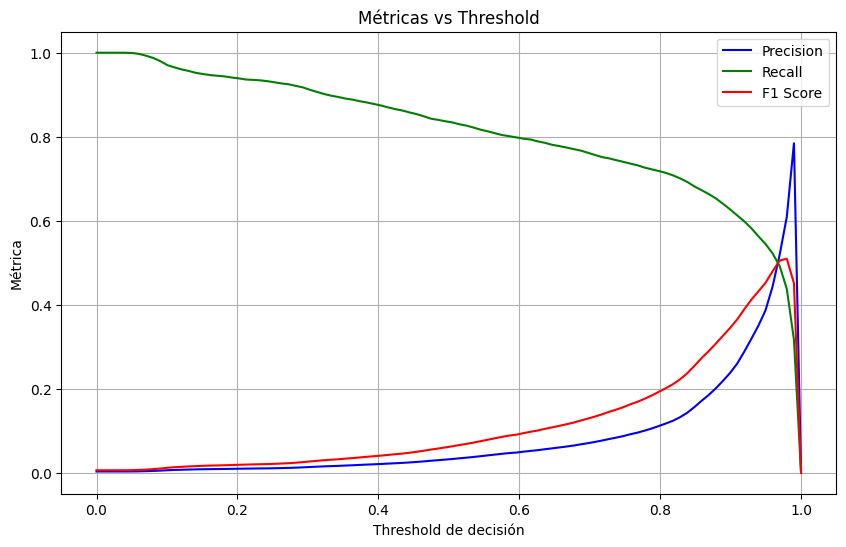

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", color="blue")
plt.plot(thresholds, recalls, label="Recall", color="green")
plt.plot(thresholds, f1_scores, label="F1 Score", color="red")
plt.xlabel("Threshold de decisión")
plt.ylabel("Métrica")
plt.title("Métricas vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


🔍 Obtener el mejor threshold

#### El fin de obtener el mejor threshold te permite maximizar el desempeño del modelo según la métrica y el objetivo del negocio o aplicación.

In [ ]:
# Encontrar el umbral que maximiza F1
idx_best_f1 = np.argmax(f1_scores)
best_threshold = thresholds[idx_best_f1]
print(f"Mejor threshold para F1: {best_threshold:.2f}")


Mejor threshold para F1: 0.98


🧪 Usar el mejor threshold en predicciones

In [ ]:
y_pred_final = (y_proba >= best_threshold).astype(int)


#### En nuestra busqueda de buenos resultados vamos a aplicar SMOTE en el dataset balanceado(1:10)

In [ ]:
# Selección de variables predictoras y variable objetivo
X = df_balanceado.drop(['isFraud'], axis=1)
y = df_balanceado['isFraud']

# Aplicación de SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Chequeo de resultados luego de aplica SMOTE e inspección si el balanceo fue realizado correctamente
print("Distribución balanceada con SMOTE:")
print(pd.Series(y_res).value_counts())

Distribución balanceada con SMOTE:
isFraud
1    82130
0    82130
Name: count, dtype: int64


#### El SMOTE es una técnica de sobremuestreo que genera ejemplos ficticios de la clase minoritaria, en nuestro caso isFraud=1.
#### Con SMOTE verificamos que la nueva distribución esté equilibrada.

In [ ]:
# Filtrar el dataframe balanceado
df_balanceado[(df_balanceado['isFraud']==0) &
 ((df_balanceado['type_CASH_OUT']==1) |
  (df_balanceado['type_TRANSFER']==1))
 ][['type_CASH_OUT','type_TRANSFER']].value_counts()

,,count
type_CASH_OUT,type_TRANSFER,
1,0,66407
0,1,15723


#### Usamos Random Forest después de aplicar SMOTE

In [ ]:
# Importación del modelo Random Forest y el reporte de métricas
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Entrenamiento del modelo

# Modelo Random Forest con 100 árboles
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenamiento con datos balanceados
rf.fit(X_res, y_res)

# Evaluación del modelo con datos reales
y_pred_rf = rf.predict(X)

# Mostrar resultados
print("Random Forest con SMOTE:")
print(classification_report(y, y_pred_rf, digits=4))

Random Forest con SMOTE:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     82130
           1     1.0000    0.9996    0.9998      8213

    accuracy                         1.0000     90343
   macro avg     1.0000    0.9998    0.9999     90343
weighted avg     1.0000    1.0000    1.0000     90343



#### Las evaluaciones anterior parecen muy buena pero tenemos que tener en cuenta que SMOTE ve todo el dataset. Para tener una evaluación más honesta vamos a dividir el dataset en entrenamiento y prueba, para utilizar así SMOTE sólo en entrenamiento.

In [ ]:
# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Aplicar SMOTE sólo para datos de entrenamiento
X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

In [ ]:
# Creación del modelo de Random Forest con datos  balanceados
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Entrenamiento del modelo con datos balanceados artificialmente
rf_model.fit(X_res, y_res)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluación del modelo sobre el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Mostrar clasificación
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9720    0.9714    0.9717     16426
           1     0.7163    0.7206    0.7184      1643

    accuracy                         0.9486     18069
   macro avg     0.8442    0.8460    0.8451     18069
weighted avg     0.9488    0.9486    0.9487     18069



#### Probamos con el modelo XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_res, y_res)

# Evaluar XGBoost en datos reales de Test
y_pred_xgb = xgb_model.predict(X_test)
print("=== XGBoost (SMOTE) ===")
print(classification_report(y_test, y_pred_xgb, digits=4))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:58:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost (SMOTE) ===
              precision    recall  f1-score   support

           0     0.9712    0.9858    0.9784     16426
           1     0.8325    0.7079    0.7651      1643

    accuracy                         0.9605     18069
   macro avg     0.9019    0.8468    0.8718     18069
weighted avg     0.9586    0.9605    0.9590     18069



#### Según los resultados necesitamos detectar la mayor cantidad de fraudes (**Alto Recall**), el mejor modelo hasta ahora es Random Forest + SMOTE
| Modelo       | Recall Fraude | Precision Fraude | ¿Más conservador?                        |
| ------------ | ------------- | ---------------- | ---------------------------------------- |
| RandomForest | ✅ **72%**   | 71%            | No (más detecta, más se equivoca)        |
| XGBoost      | 70.8%         | ✅ **83%**        | Sí (menos detecciones, pero más seguras) |


#### Intentamos mejorar los resultados con modificacion de hiperparametros (GridSearch)

In [ ]:
# Definimos el scoring y el modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Vamos a optimizar el recall de la clase 1 (fraudes)
recall_scorer = make_scorer(recall_score, pos_label=1)


##### Aplicamos los hiperparámetros

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']  # importante para mejorar recall
}

#### Usamos GridSearch

In [ ]:
# Usamos X_res, y_rest que son los balaceados por SMOTE
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=5,
    n_jobs=-1,         # usa todos los núcleos disponibles
    verbose=2
)

grid_search.fit(X_res, y_res)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
             verbose=2)

###### Los mejores parámetros

In [ ]:
0print(grid_search.best_params_)

print("Mejor recall obtenido:")
print(grid_search.best_score_)


Mejores parámetros encontrados:
{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor recall obtenido:
0.9507187619771367


#### Hacemos una prueba con los mejores parámetros para Random Forest

In [ ]:
rf_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth= None,
    min_samples_leaf= 1,
    min_samples_split= 2,
    n_estimators=200,
    random_state=42
)
rf_model.fit(X_res, y_res)

#{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [ ]:
0print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9719    0.9711    0.9715     16426
           1     0.7136    0.7188    0.7162      1643

    accuracy                         0.9482     18069
   macro avg     0.8427    0.8450    0.8438     18069
weighted avg     0.9484    0.9482    0.9483     18069



In [ ]:
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Matriz de confusión:
[[15952   474]
 [  462  1181]]


##### Ahora probamos GridSearch con el modelo XGBoost

In [ ]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Definimos la métrica de evaluación como recall para la clase 1
recall_scorer = make_scorer(recall_score, pos_label=1)


##### Definimos los parámetros

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [1, 5, 10]  # Muy importante para clases desbalanceadas
}


##### Aplicamos GridSearcxh



In [ ]:
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_res, y_res)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200],
                         'scale_pos_weight': [1, 5, 10],
                         'subsample': [0.8, 1.0]},
             scoring=make_scorer(recall_score, response_method='predict', pos_label=1),
             verbose=2)

#### Mejores estimadores

In [ ]:
 print("Mejores hiperparámetros:")
print(grid_search.best_params_)

print("Mejor recall en validación cruzada:")
print(grid_search.best_score_)


Mejores hiperparámetros:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 10, 'subsample': 0.8}
Mejor recall en validación cruzada:
1.0


#### Con todos estos resultados vamos a probarlos sobre los datos reales sin SMOTE

In [ ]:
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

print("Reporte de clasificación en datos reales:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))


Reporte de clasificación en datos reales:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     16426
           1       0.09      1.00      0.17      1643

    accuracy                           0.09     18069
   macro avg       0.05      0.50      0.08     18069
weighted avg       0.01      0.09      0.02     18069

Matriz de confusión:
[[    0 16426]
 [    0  1643]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Voy a usar scale_pos_weight que balancea un poco más

In [ ]:
# Calculamos el peso: cantidad de no-fraude / cantidad de fraude
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

# Modelo XGBoost
xgb = XGBClassifier(
    eval_metric=['aucpr', 'logloss'],
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

#'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100,
#'scale_pos_weight': 5, 'subsample': 0.8}
# Validación cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Obtener predicciones cruzadas
y_pred = cross_val_predict(xgb, X, y, cv=cv)

# Calcular métricas
f1 = f1_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

# Mostrar resultados
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("\nMatriz de Confusión:\n", cm)

# Opcional: informe completo
print("\nReporte completo:\n", classification_report(y, y_pred))


F1 Score: 0.6364663778489358
Precision: 0.5189280503724181
Recall: 0.8228418361134786

Matriz de Confusión:
 [[75865  6265]
 [ 1455  6758]]

Reporte completo:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     82130
           1       0.52      0.82      0.64      8213

    accuracy                           0.91     90343
   macro avg       0.75      0.87      0.79     90343
weighted avg       0.94      0.91      0.92     90343



Ajustar el umbral de decisión (threshold) para mejorar recall

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


In [ ]:
# Modelo XGBoost
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
threshold = 0.7  # Ajustamos umbral para mejorar recall (probar otros como 0.25, 0.2 también)
fold_metrics = []

# Cross-validation manual para poder ajustar umbral y guardar métricas por fold
for i, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


    # Entrenar
    xgb.fit(X_train, y_train)

    # Predecir probabilidades
    y_proba = xgb.predict_proba(X_val)[:, 1]

    # Aplicar umbral manual
    y_pred = (y_proba >= threshold).astype(int)

    # Calcular métricas
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    # Guardar
    fold_metrics.append({
        'fold': i,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    })

# Mostrar resultados
for fm in fold_metrics:
    print(f"Fold {fm['fold']}:")
    print(f"  Precision: {fm['precision']:.4f}")
    print(f"  Recall:    {fm['recall']:.4f}")
    print(f"  F1 Score:  {fm['f1_score']:.4f}")
    print(f"  Matriz de Confusión:\n{fm['confusion_matrix']}\n")

# Promedios
avg_precision = np.mean([f['precision'] for f in fold_metrics])
avg_recall = np.mean([f['recall'] for f in fold_metrics])
avg_f1 = np.mean([f['f1_score'] for f in fold_metrics])

print("Promedio en 10 folds:")
print(f"  Precision: {avg_precision:.4f}")
print(f"  Recall:    {avg_recall:.4f}")
print(f"  F1 Score:  {avg_f1:.4f}")


Fold 1:
  Precision: 0.7275
  Recall:    0.7470
  F1 Score:  0.7371
  Matriz de Confusión:
[[7983  230]
 [ 208  614]]

Fold 2:
  Precision: 0.7582
  Recall:    0.7324
  F1 Score:  0.7450
  Matriz de Confusión:
[[8021  192]
 [ 220  602]]

Fold 3:
  Precision: 0.7106
  Recall:    0.7470
  F1 Score:  0.7284
  Matriz de Confusión:
[[7963  250]
 [ 208  614]]

Fold 4:
  Precision: 0.7221
  Recall:    0.7406
  F1 Score:  0.7312
  Matriz de Confusión:
[[7979  234]
 [ 213  608]]

Fold 5:
  Precision: 0.7196
  Recall:    0.7564
  F1 Score:  0.7375
  Matriz de Confusión:
[[7971  242]
 [ 200  621]]

Fold 6:
  Precision: 0.7387
  Recall:    0.7540
  F1 Score:  0.7462
  Matriz de Confusión:
[[7994  219]
 [ 202  619]]

Fold 7:
  Precision: 0.7082
  Recall:    0.7479
  F1 Score:  0.7275
  Matriz de Confusión:
[[7960  253]
 [ 207  614]]

Fold 8:
  Precision: 0.7173
  Recall:    0.7418
  F1 Score:  0.7293
  Matriz de Confusión:
[[7973  240]
 [ 212  609]]

Fold 9:
  Precision: 0.7140
  Recall:    0.7540


##### Probando varios threshold

In [ ]:
# Explorar múltiples thresholds
thresholds = np.linspace(0.1, 0.9, 9)
mejores_f1 = {}
X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

for th in thresholds:
    fold_f1 = []
    for train_idx, val_idx in cv.split(X, y):
        xgb.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_proba = xgb.predict_proba(X.iloc[val_idx])[:, 1]
        y_pred = (y_proba >= th).astype(int)
        fold_f1.append(f1_score(y.iloc[val_idx], y_pred))
    mejores_f1[th] = np.mean(fold_f1)

best_th = max(mejores_f1, key=mejores_f1.get)
print(f"Mejor threshold para F1: {best_th:.2f} con F1 promedio: {mejores_f1[best_th]:.4f}")


Mejor threshold para F1: 0.80 con F1 promedio: 0.7581


#### Usando las mejores metricas para xgboost, buscando el mejor threshold

In [ ]:
# Configuración
thresholds = np.linspace(0.6, 0.9, 4)
mejores_f1 = {}

# Modelo
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
xgb = XGBClassifier(
    scale_pos_weight=5, #5 es la mejor
    n_estimators=100,
    max_depth=3,
    random_state=42,
    #learning_rate= 0.01,
    subsample= 0.8
)

# Validación cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Probar varios thresholds
for th in thresholds:
    fold_f1 = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        xgb.fit(X_train, y_train)
        y_proba = xgb.predict_proba(X_val)[:, 1]
        y_pred = (y_proba >= th).astype(int)

        f1 = f1_score(y_val, y_pred)
        fold_f1.append(f1)

    promedio_f1 = np.mean(fold_f1)
    mejores_f1[th] = promedio_f1
    print(f"Threshold: {th:.2f} -> F1 promedio: {promedio_f1:.4f}")

# Buscar el mejor threshold
best_th = max(mejores_f1, key=mejores_f1.get)
print(f"\n🔍 Mejor threshold: {best_th:.2f} con F1 promedio: {mejores_f1[best_th]:.4f}")


Threshold: 0.60 -> F1 promedio: 0.7369
Threshold: 0.70 -> F1 promedio: 0.7517
Threshold: 0.80 -> F1 promedio: 0.7476
Threshold: 0.90 -> F1 promedio: 0.7141

🔍 Mejor threshold: 0.70 con F1 promedio: 0.7517


#### Hacemos una comparativa entre Submuestro(1 Fraude ≡ 5 No Fraude), Sobremuestreo(Fraude *5 datos sinteticos) y Smote(0.2) en el dataset completo con los  2 millones de registros

In [ ]:
# Comparación de tres métodos de balanceo de clases: undersampling, oversampling y SMOTE
def comparar_balanceos(df, target='isFraud', ratio_undersample=5, ratio_oversample=5, smote_ratio=0.2):
    resultados = {}
    modelos = {}

# Separar clases: fraudes (1) y no fraudes (0)
    fraudes = df[df[target] == 1]
    no_fraudes = df[df[target] == 0]

# UNDERSAMPLING
    no_fraudes_under = no_fraudes.sample(n=len(fraudes) * ratio_undersample, random_state=42)
    df_under = pd.concat([fraudes, no_fraudes_under]).sample(frac=1, random_state=42)

# OVERSAMPLING
    fraudes_over = pd.concat([fraudes] * ratio_oversample, ignore_index=True)
    df_over = pd.concat([no_fraudes, fraudes_over]).sample(frac=1, random_state=42)

# SMOTE
    X = df.drop(columns=target)
    y = df[target]
    sm = SMOTE(sampling_strategy=smote_ratio, random_state=42)
    X_sm, y_sm = sm.fit_resample(X, y)


    datasets = {
        'Undersampling': (df_under.drop(columns=target), df_under[target]),
        'Oversampling': (df_over.drop(columns=target), df_over[target]),
        'SMOTE': (X_sm, y_sm)
    }

# Entrenamiento y evaluación de un modelo Random Forest sobre cada conjunto balanceado
    for metodo, (Xb, yb) in datasets.items():
        clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        y_pred = cross_val_predict(clf, Xb, yb, cv=5, method='predict')

# Cálculo de métricas de evaluación
        f1 = f1_score(yb, y_pred)
        prec = precision_score(yb, y_pred)
        rec = recall_score(yb, y_pred)
        cm = confusion_matrix(yb, y_pred)

        resultados[metodo] = {'F1': f1, 'Precision': prec, 'Recall': rec}
        modelos[metodo] = cm

# Mostrar métricas comparadas entre métodos
    print(pd.DataFrame(resultados).T)

# Mostrar matriz de confusión de cada método
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    for i, (metodo, cm) in enumerate(modelos.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i])
        axs[i].set_title(metodo)
        axs[i].set_xlabel('Predicción')
        axs[i].set_ylabel('Real')

    plt.tight_layout()
    plt.show()


                     F1  Precision    Recall
Undersampling  0.751388   0.789199  0.717034
Oversampling   0.949550   0.904245  0.999635
SMOTE          0.287716   0.168309  0.990249


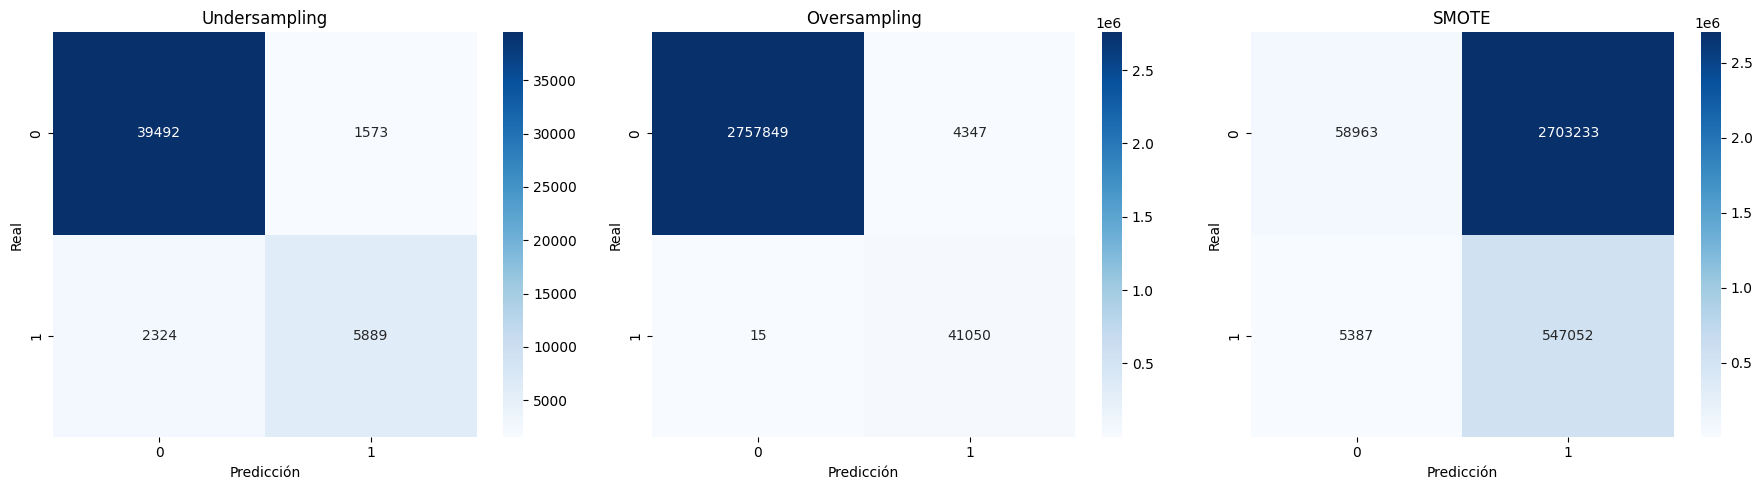

In [ ]:
# Comparación de balanceos
comparar_balanceos(df_final)


#### De la compración de los tres métodos de balanceo podemos decir:
<br>

##### - UNDERSAMPLING:
##### Buen equilibrio entre precición y recall. El F1-score es moderadamente alto, por lo que está equilibrado.
##### Clasifica bien las dos categorías (fraude y no fraude), pero hay muchos falsos negativos.
<br>

##### - OVERSAMPLING
##### Precisión y recall altos, indica que tiene buena detección de fraudes. F1-score muy alto.
#### Pocos falsos negativos. Algunos falsos positivos (tolerables por el alto recall).
<br>

##### - SMOTE
##### Recall cercano a la unidad, detecta casi todos los fraudes. Precisión muy baja, muchos falsos positivos. F1-score bajo, indica desequilibrio.
#### Genera muchos falsos positivos.
<br>

##### Podemos concluir que si queremos detectar fraudes con mayor efectividad, el OVERSAMPLING es el más adecuado.
##### Pero si buscamos una menor tasa de falsas alarmas, el UNDERSAMPLIG es preferible.
